In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.2 MB/s eta 0:00:0000:01


# Data Processing

In [1]:
import math
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
from scipy.stats import multivariate_normal

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.module import Module

import torch_geometric
from torch_geometric.nn import GCNConv

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f'using {device}')

# Set random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  

using cpu


In [3]:
# Antivectorize given vector into adjacency matrix
def antiVectorize(vec, m):
    M = np.zeros((m,m))
    M[np.tril_indices(m,k=-1)] = vec
    M= M.transpose()
    M[np.tril_indices(m,k=-1)] = vec
    return M

# Vectorize graph adjacency matrix into a vector
def vectorize(M):
    return M[np.tril_indices(M.shape[0], k=-1)]

### Load Dataset

#### Load Simulated Dataset

In [4]:
def multivariate_simulate(datapath, n_samples=200,n_time=2,n_views=4):
    # Note that changing the node count is not provided right now, since we use correlation matrix
    # and the mean values of connectivities from real data and it is for 35 nodes.
    
    # Import all required statistical information.
    allstats = np.load(datapath + "stats/REAL_TIME_DIFF.npy") # Connectivity mean values of LH. You can also try with RH.
    allcorrs = np.load(datapath + "stats/REAL_TIME_DIFF.npy") # Correlation matrix in LH. You can also try with RH.
    all_diffs = np.load(datapath + "stats/REAL_TIME_DIFF.npy") # This is an overall representation of time differences in both (LH and RH) datasets.
    
    times = []
    for t in range(n_time):
        views = []
        for v in range(n_views):
            # Note that we randomly assign a new random state to ensure it will generate a different dataset at each run.
            # Generate data with the correlations and mean values at the current timepoint.
            if t < 2:
                connectomic_means = allstats[t,v]
                data = multivariate_normal.rvs(connectomic_means,allcorrs[t,v],n_samples,random_state=randint(1,9999))
            # If the requested timepoints are more than we have in real data, use the correlation information from the last timepoint.
            else:
                connectomic_means = allstats[-1,v]
                data = multivariate_normal.rvs(connectomic_means,allcorrs[-1,v],n_samples,random_state=randint(1,9999))

            adj = []
            for idx, sample in enumerate(data):
                # Create adjacency matrix.
                matrix = antiVectorize(sample,35)
                # Perturb the real time difference with nonlinear tanh function.
                noise = np.tanh( t / n_time )
                # Further timepoints will have more significant difference from the baseline (t=6 >> t=1).
                matrix = matrix + all_diffs[:,:,v] * ( noise + 1 )
                adj.append(matrix)
            views.append(np.array(adj))

        times.append(np.array(views))
    
    alldata=np.array(times)
    alldata = np.transpose(alldata,(2,0,3,4,1))
    return alldata 

def prepare_data(datapath, new_data=False, n_samples=200, n_times=6):
    # Note that data with 200 samples and 6 timepoints is very large (5.8M data points),
    # check your GPU memory to make sure there is enough space to allocate. If not, try:
    # - to reduce dataset size by changing n_samples or n_times.
    # - on CPU (this will allocate memory on RAM) --> This might work for example if you have 1GB GPU memory but 16GB RAM.
    # - on another computer with a better NVIDIA graphics card. --> 2GB GPU memory will not be enough for 5.8M data.
    try:
        if new_data:
            samples = multivariate_simulate(n_samples,n_times)
            np.save(datapath + 'multivariate_simulation_data.npy',samples)
        else:
            samples = np.load(datapath + 'multivariate_simulation_data.npy')
    except:
        samples = multivariate_simulate(n_samples,n_times)
        np.save(datapath + 'multivariate_simulation_data.npy',samples)
    return samples

In [5]:
dataset_path = "/Users/gitaayusalsabila/Documents/0thesis/code/sandbox/dataset/"
# dataset_path = "/notebooks/dataset/"
simulated_data = prepare_data(dataset_path, new_data=False, n_samples=100, n_times=3)
simulated_data.shape

(100, 3, 35, 35, 4)

#### Load SLIM Dataset

# Pre-processing and Cleansing

In [6]:
# dataset declaration
dataset = simulated_data
num_graphs, num_timepoints, num_nodes, _, num_domains = dataset.shape

### Negative and NaN values cleansing

In [7]:
def data_cleansing(dataset):
    # Replace negative values with 0
    dataset[dataset < 0] = 0
    
    # Replace NaN values with 0
    dataset = np.nan_to_num(dataset, nan=0)
    
    return dataset

In [8]:
dataset_cleaned = data_cleansing(dataset)
dataset_cleaned.shape

(100, 3, 35, 35, 4)

### Node Feature Initialization

In [9]:
from scipy.sparse.linalg import eigsh
from scipy.sparse import csgraph

def laplacian_positional_encoding(adj_matrix, dim):
    laplacian = csgraph.laplacian(adj_matrix, normed=True)
    eigvals, eigvecs = eigsh(laplacian, k=dim + 1, which='SM')
    return torch.tensor(eigvecs[:, 1:], dtype=torch.float)  # Skip the first eigenvector

def node_feature_initialization(graphs, num_graphs, num_timepoints, num_domains, num_nodes, feature_dim=16):
    node_features = np.zeros((num_graphs, num_timepoints, num_nodes, feature_dim, num_domains))

    for i in range(num_graphs):
        for t in range(num_timepoints):
            for d in range(num_domains):
                adj_matrix = graphs[i, t, :, :, d]
                node_features[i, t, :, :, d] = laplacian_positional_encoding(adj_matrix, feature_dim)
    return node_features

In [10]:
node_features = node_feature_initialization(dataset_cleaned, num_graphs, num_timepoints, num_domains, num_nodes)
node_features.shape

(100, 3, 35, 16, 4)

### Graph Normalization

In [12]:
def normalize_adj_matrix(adj):
    # Calculate the degree matrix
    degrees = np.sum(adj, axis=1) # Sum of weights for each node
    degrees[degrees == 0] = 1
    D_hat_inv_sqrt = np.diag(1.0 / np.sqrt(degrees))
    
    # Perform the normalization
    normalized_adj = D_hat_inv_sqrt.dot(adj).dot(D_hat_inv_sqrt)
    
    return normalized_adj

def normalize_graph_dataset(dataset):
    normalized_dataset = np.zeros_like(dataset)
    num_graphs, num_timepoints, _, _, num_domain = dataset.shape
    
    for i in range(num_graphs):
        for t in range(num_timepoints):
            for d in range(num_domain):
                adjacency_matrix = dataset[i, t, :, :, d]
                normalized_adjacency_matrix = normalize_adj_matrix(adjacency_matrix)
                normalized_dataset[i, t, :, :, d] = normalized_adjacency_matrix
    
    return normalized_dataset

In [13]:
dataset_normalized = normalize_graph_dataset(dataset_cleaned)
dataset_normalized.shape

(100, 3, 35, 35, 4)

### Data Visualization (checking)

In [14]:
# Visualizing Adjacency Matrices for Each Graph, Time Point, and View
def plot_heatmaps(X, num_samples=3):
    num_graphs, num_timepoints, num_nodes, _, num_views = X.shape
    fig, axs = plt.subplots(num_samples * num_views, num_timepoints, figsize=(15, 5 * num_samples * num_views))
    
    for i in range(num_samples):
        for v in range(num_views):
            for t in range(num_timepoints):
                ax = axs[i * num_views + v, t]
                sns.heatmap(X[i, t, :, :, v], ax=ax, cmap="YlGnBu")
                ax.set_title(f"Graph {i+1}, View {v+1}, Timepoint {t+1}")
                ax.axis('off')
    
    plt.tight_layout()
    plt.show()

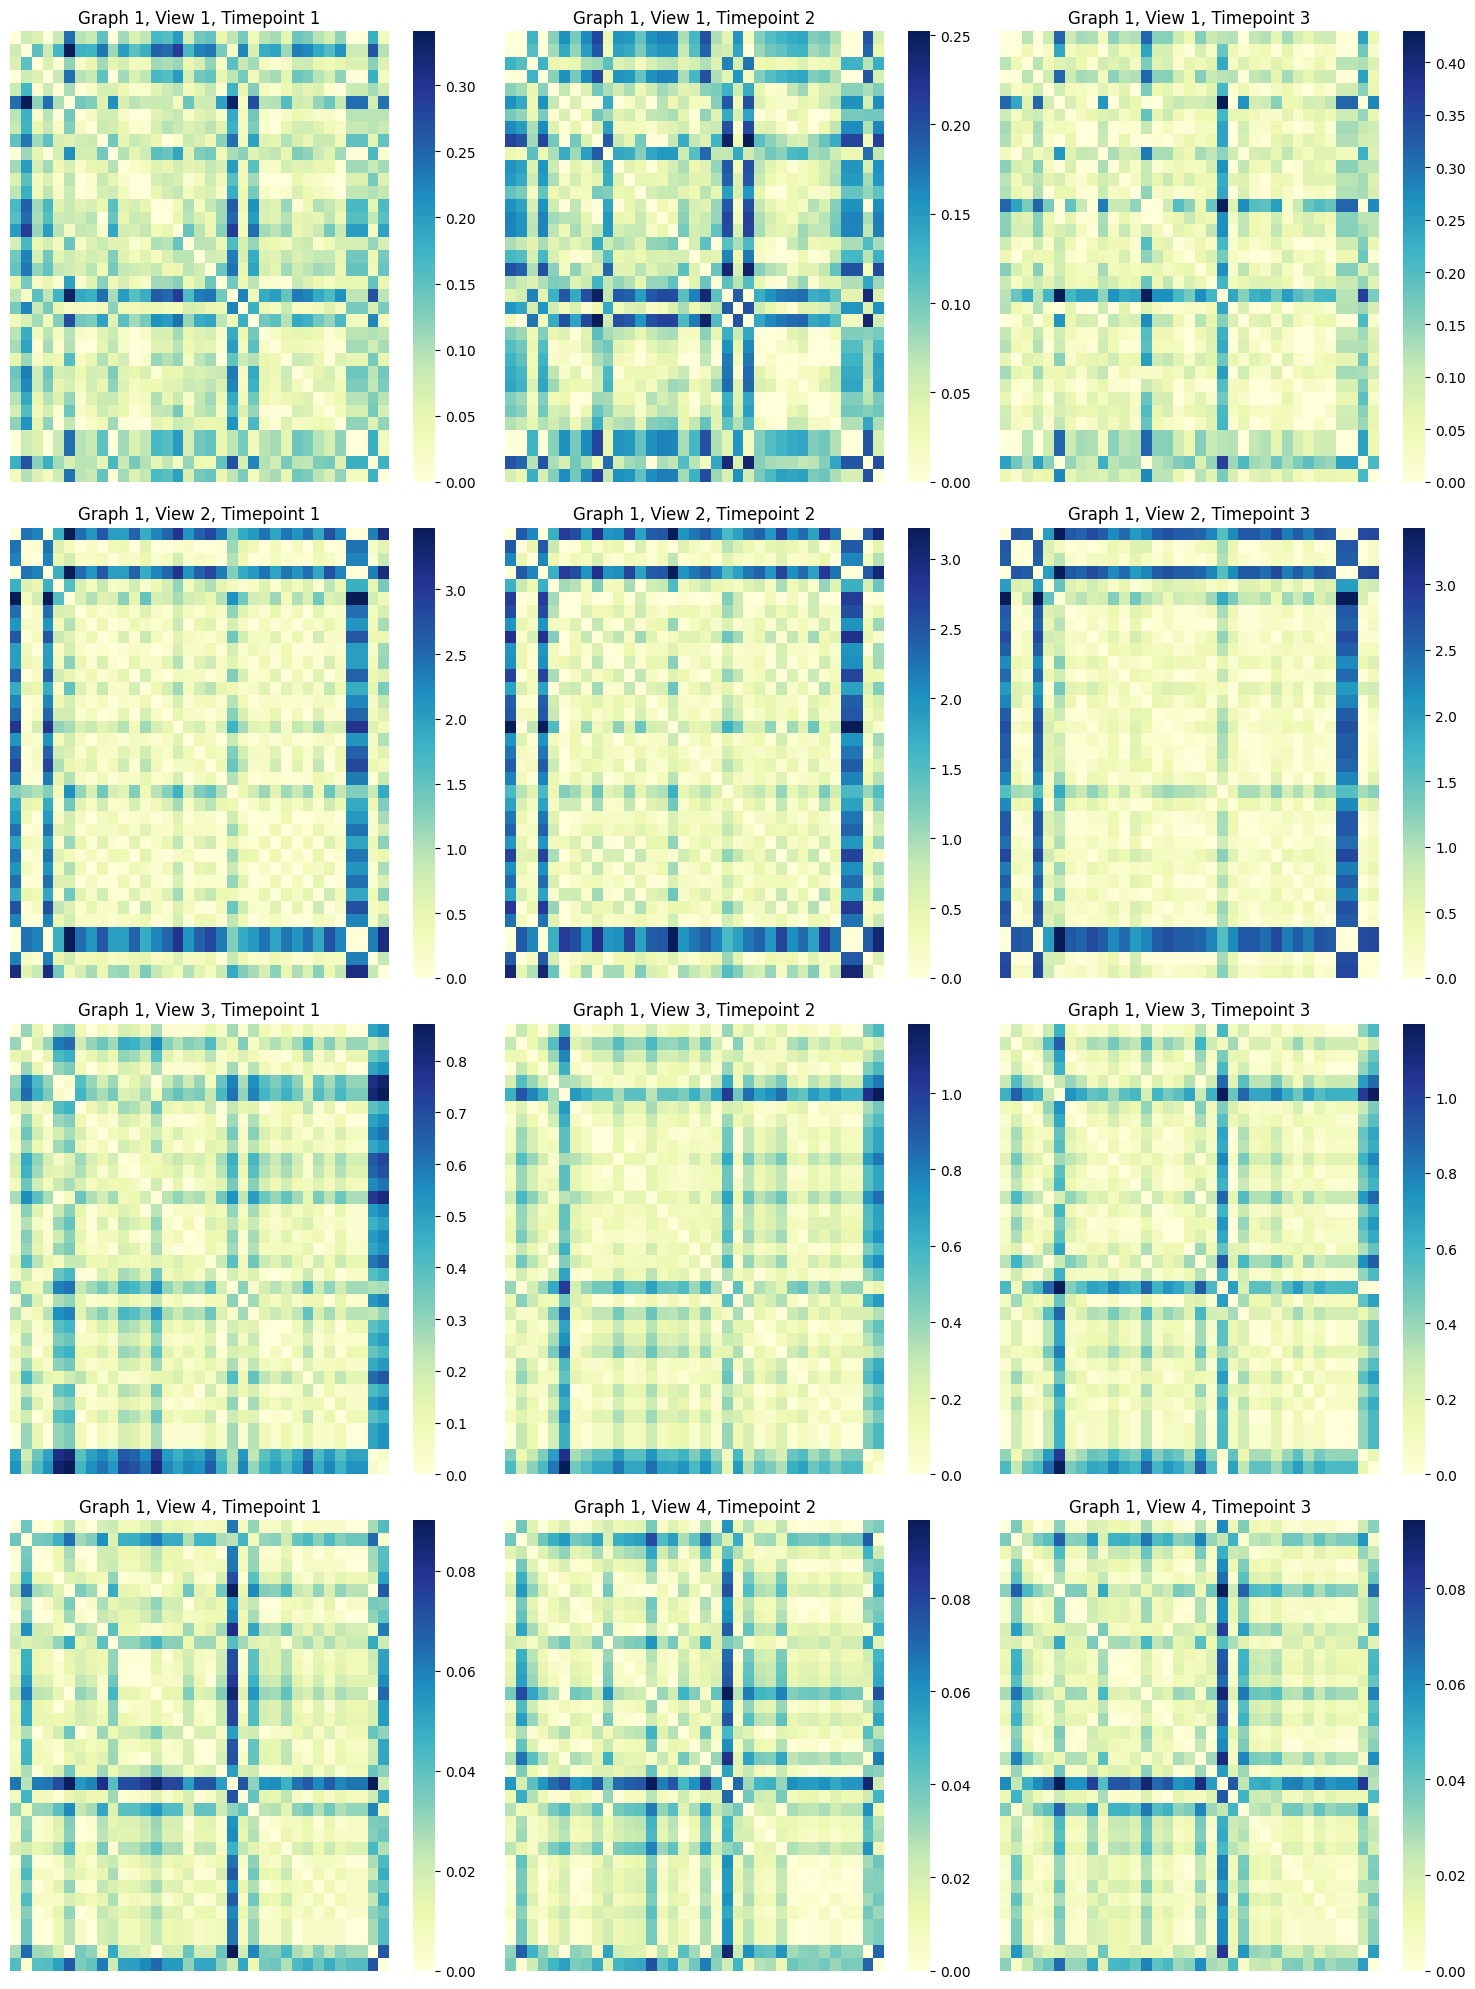

In [17]:
plot_heatmaps(dataset, num_samples=1)

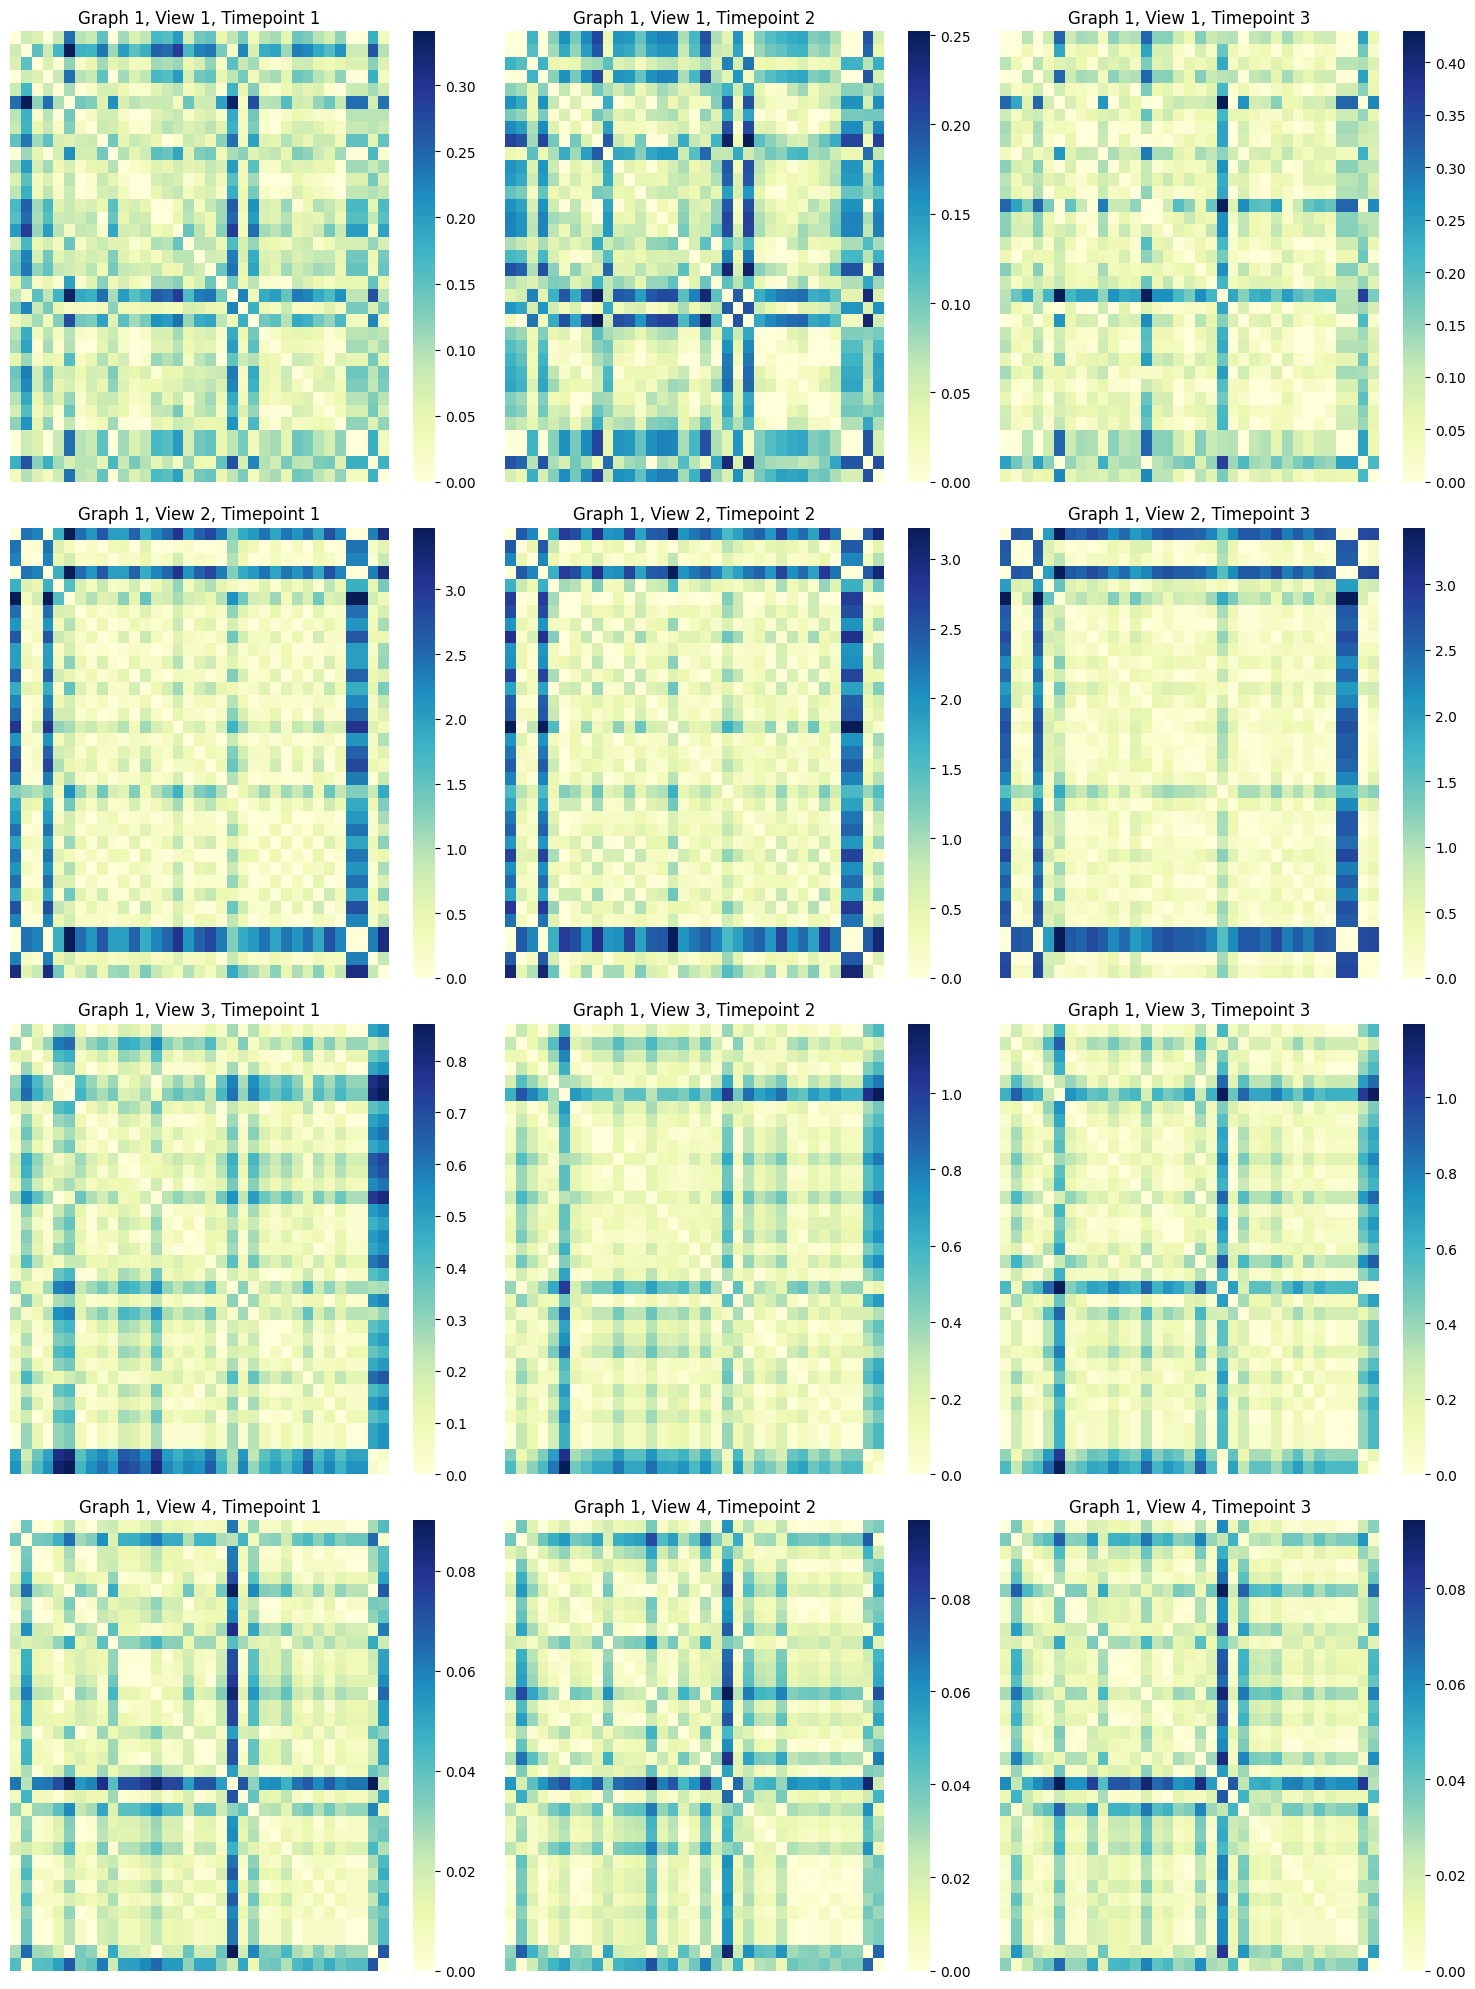

In [18]:
plot_heatmaps(dataset_cleaned, num_samples=1)

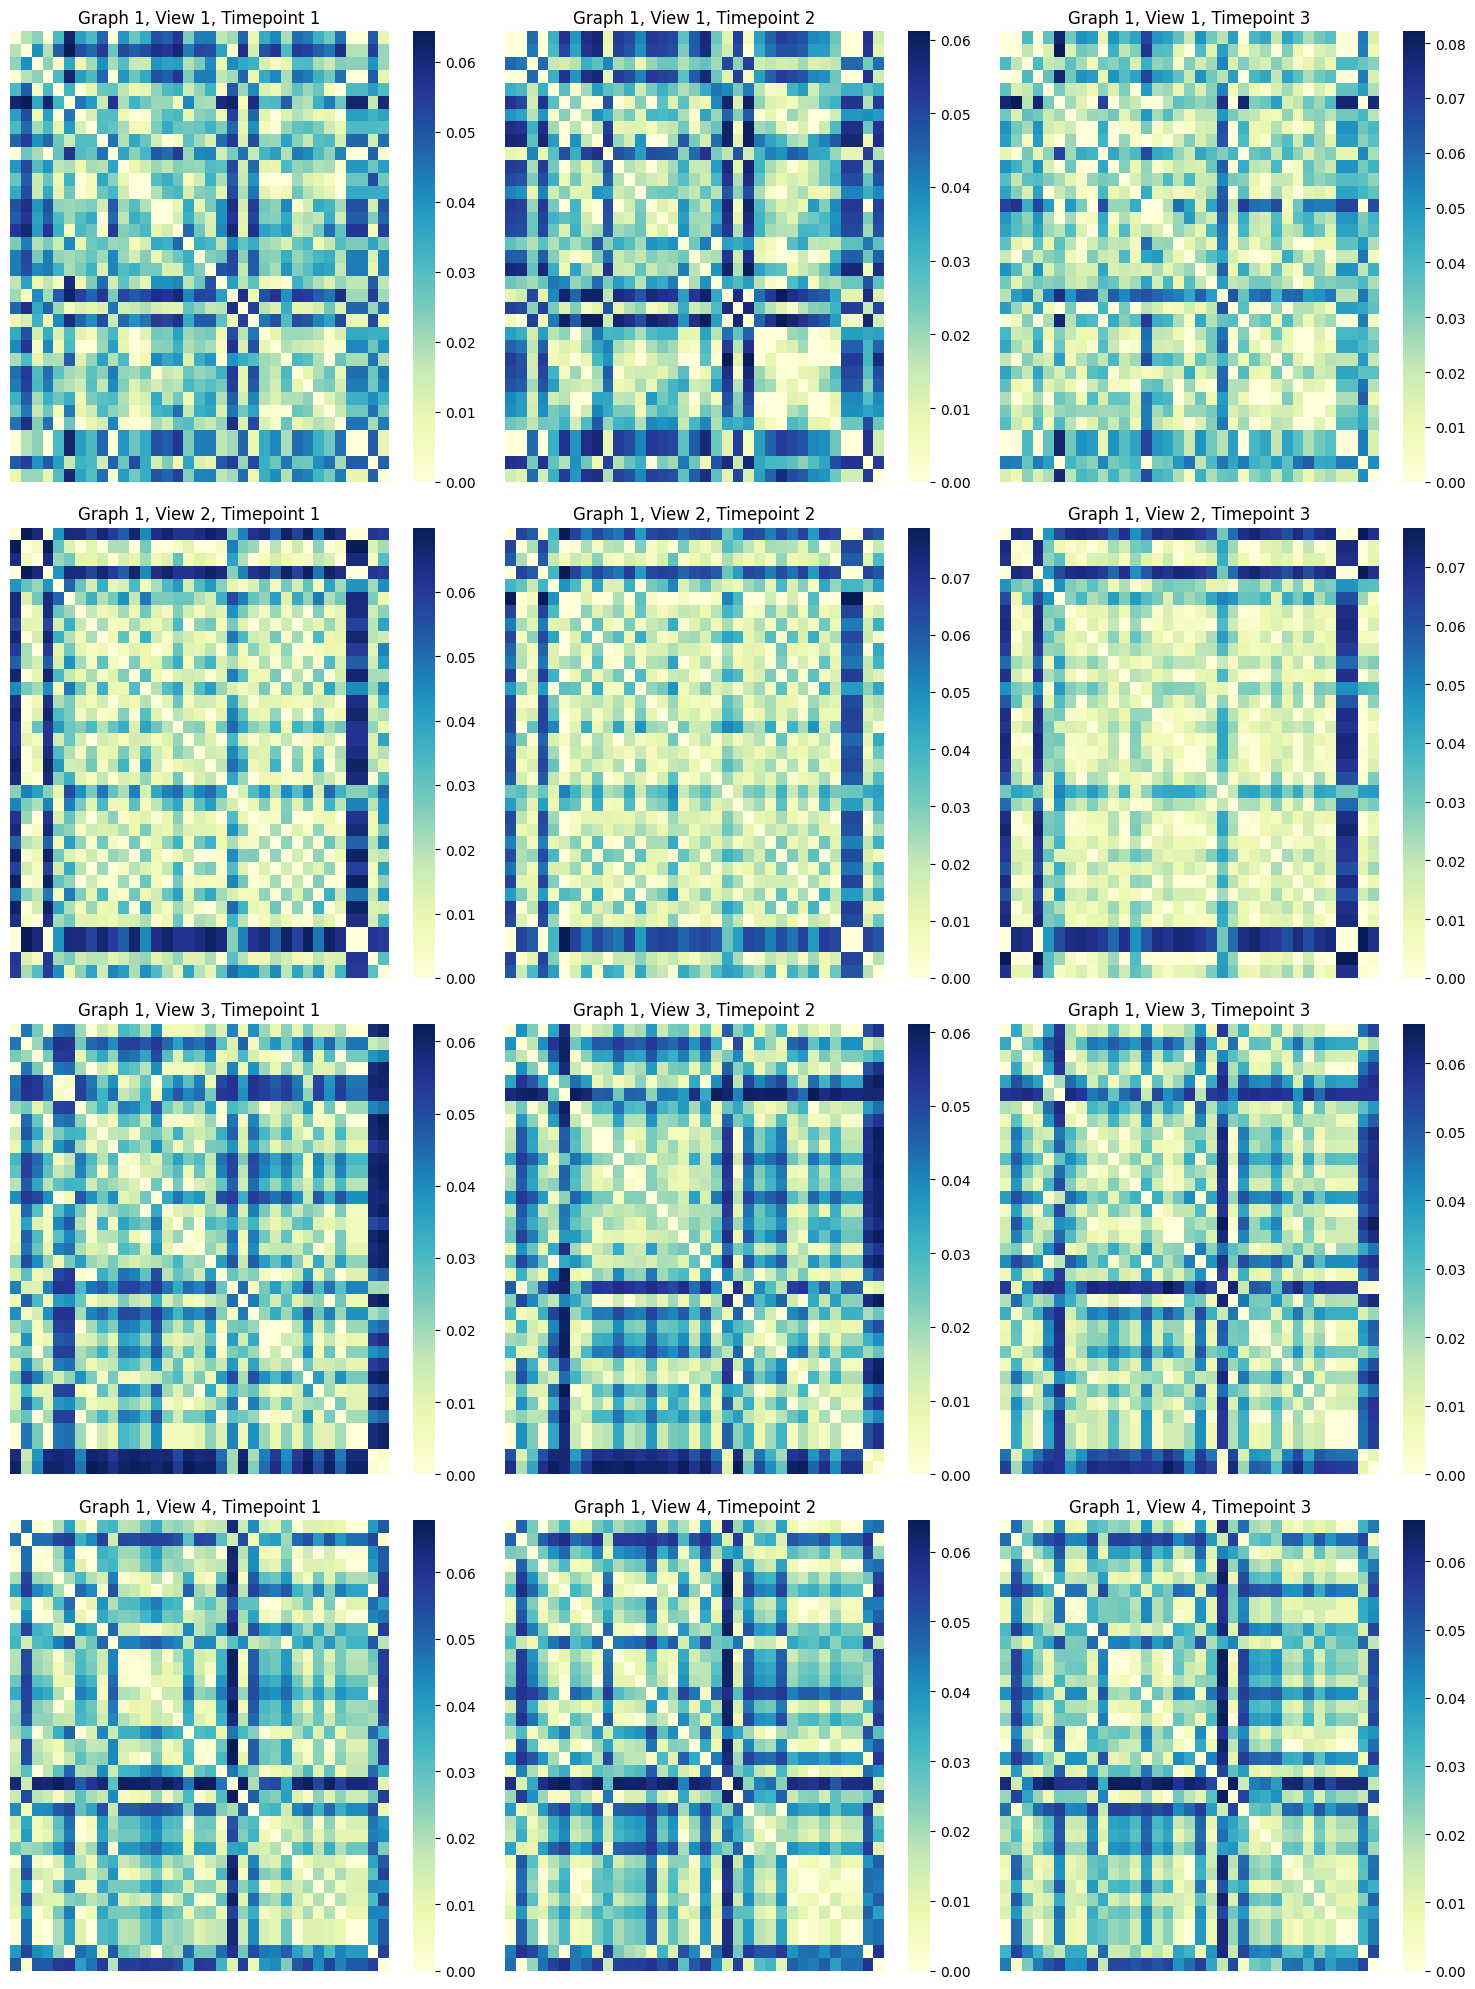

In [19]:
plot_heatmaps(dataset_normalized, num_samples=1)

### Split Train and Test Set

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split

# Function to split the dataset into training and test sets for each domain
def split_dataset_by_domain(adj_matrix, node_features, test_size=0.2, random_state=42):
    num_subjects, num_timepoints, num_nodes, num_features, num_domains = node_features.shape
    
    # Initialize lists to store train and test sets for each domain
    adj_train_sets, adj_test_sets = [], []
    features_train_sets, features_test_sets = [], []
    
    for domain in range(num_domains):
        # Extract data for the current domain
        adj_domain = adj_matrix[..., domain]
        features_domain = node_features[..., domain]
        
        # Generate subject labels
        subject_labels = np.arange(num_subjects)
        
        # Split the dataset for the current domain
        train_idx, test_idx = train_test_split(subject_labels, test_size=test_size, random_state=random_state)
        
        # Create train and test sets for the current domain
        adj_train, adj_test = adj_domain[train_idx], adj_domain[test_idx]
        features_train, features_test = features_domain[train_idx], features_domain[test_idx]
        
        # Append the train and test sets to the lists
        adj_train_sets.append(adj_train)
        adj_test_sets.append(adj_test)
        features_train_sets.append(features_train)
        features_test_sets.append(features_test)
    
    return adj_train_sets, adj_test_sets, features_train_sets, features_test_sets

adj_matrix = dataset_cleaned
# Split the dataset by domain
adj_train_sets, adj_test_sets, features_train_sets, features_test_sets = split_dataset_by_domain(adj_matrix, node_features)

adj_train_domains = []
features_train_domains = []
adj_test_domains = []
features_test_domains = []

for domain in range(num_domains):
    print(f'Domain {domain+1} - Adjacency Train set shape: {adj_train_sets[domain].shape}, Test set shape: {adj_test_sets[domain].shape}')
    print(f'Domain {domain+1} - Node Features Train set shape: {features_train_sets[domain].shape}, Test set shape: {features_test_sets[domain].shape}')
    
    adj_train_domains.append(torch.tensor(adj_train_sets[domain], dtype=torch.float32))
    features_train_domains.append(torch.tensor(features_train_sets[domain], dtype=torch.float32))
    adj_test_domains.append(torch.tensor(adj_test_sets[domain], dtype=torch.float32))
    features_test_domains.append(torch.tensor(features_test_sets[domain], dtype=torch.float32))

Domain 1 - Adjacency Train set shape: (80, 3, 35, 35), Test set shape: (20, 3, 35, 35)
Domain 1 - Node Features Train set shape: (80, 3, 35, 16), Test set shape: (20, 3, 35, 16)
Domain 2 - Adjacency Train set shape: (80, 3, 35, 35), Test set shape: (20, 3, 35, 35)
Domain 2 - Node Features Train set shape: (80, 3, 35, 16), Test set shape: (20, 3, 35, 16)
Domain 3 - Adjacency Train set shape: (80, 3, 35, 35), Test set shape: (20, 3, 35, 35)
Domain 3 - Node Features Train set shape: (80, 3, 35, 16), Test set shape: (20, 3, 35, 16)
Domain 4 - Adjacency Train set shape: (80, 3, 35, 35), Test set shape: (20, 3, 35, 35)
Domain 4 - Node Features Train set shape: (80, 3, 35, 16), Test set shape: (20, 3, 35, 16)


# Model

### Definition

In [63]:
class GCN(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GCN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        # print("gcn weight init:",self.weight.size())
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        # print("gcn weight forward:",self.weight.size())
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'


class GCNEncoder(nn.Module):
    def __init__(self, input_dim, feature_dim):
        super(GCNEncoder, self).__init__()
        self.num_nodes = input_dim
        self.feature_dim = feature_dim
        self.hidden_dim = 2 * feature_dim
        self.latent_dim = feature_dim
        
        # GCN layers
        self.conv1 = GCN(feature_dim, self.hidden_dim)
        self.bn1 = nn.BatchNorm1d(self.hidden_dim)
        self.conv2 = GCN(self.hidden_dim, self.latent_dim)
        self.bn2 = nn.BatchNorm1d(self.latent_dim)
        
        self.fc_mu = nn.Linear(self.latent_dim, self.latent_dim)
        self.fc_logvar = nn.Linear(self.latent_dim, self.latent_dim)

    def forward(self, x, adj):
        # GCN layers
        x = F.relu(self.bn1(self.conv1(x, adj)))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.bn2(self.conv2(x, adj)))
        x = F.dropout(x, training=self.training)
        
        # Node features properties
        x_mean = x.mean(dim=0)
        mu = self.fc_mu(x_mean)
        logvar = self.fc_logvar(x_mean)

        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        
        return z, mu, logvar


class InnerProductDecoder(nn.Module):
    def __init__(self, act=torch.sigmoid, dropout=0.):
        super(InnerProductDecoder, self).__init__()
        self.act = act
        self.dropout = dropout
    
    def forward(self, inp):
        inp = F.dropout(inp, self.dropout, training=self.training)
        x = torch.transpose(inp, dim0=0, dim1=1)
        x = torch.mm(inp, x)
        return self.act(x)


class GCNDecoder(nn.Module):
    def __init__(self, latent_dim, num_nodes):
        super(GCNDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.num_nodes = num_nodes
        
        # Fully connected layer to expand z to node features
        self.fc = nn.Linear(latent_dim, num_nodes * latent_dim)
        
        # GCN layers
        self.conv1 = GCN(latent_dim, latent_dim * 2)
        self.bn1 = nn.BatchNorm1d(latent_dim * 2)
        self.conv2 = GCN(latent_dim * 2, latent_dim)
        self.bn2 = nn.BatchNorm1d(latent_dim)
        
        # Fully connected layer to generate adjacency matrix
        # self.fc_adj = nn.Linear(latent_dim, num_nodes * num_nodes)

    def forward(self, z):
        # Expand z to initial node features
        x = self.fc(z).view(self.num_nodes, self.latent_dim)
        
        # Initial adjacency matrix (identity matrix)
        adj = torch.eye(self.num_nodes, device=z.device)
        # print("adj init size in decoder",x.size())

        # Pass through GCN layers
        x = F.relu(self.bn1(self.conv1(x, adj)))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.bn2(self.conv2(x, adj)))
        x = F.dropout(x, training=self.training)
        # print("x size in decoder",x.size())
        
        # # Generate adjacency matrix
        adj_pred = x #torch.sigmoid(x)

        # # Ensure symmetry of the adjacency matrix
        adj_pred = (adj_pred + adj_pred.T) / 2
        
        return adj_pred


class FFNDecoder(nn.Module):
    def __init__(self, latent_dim, num_nodes):
        super(GCNDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.num_nodes = num_nodes
        
        # Fully connected layers to generate the adjacency matrix
        self.fc1 = nn.Linear(latent_dim, latent_dim * 2)
        self.fc2 = nn.Linear(latent_dim * 2, num_nodes * num_nodes)

    def forward(self, z):
        # Pass through fully connected layers
        x = F.relu(self.fc1(z))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        # Reshape to the adjacency matrix
        adj_pred = torch.sigmoid(x.view(self.num_nodes, self.num_nodes))

        # Ensure symmetry of the adjacency matrix
        adj_pred = (adj_pred + adj_pred.T) / 2
        
        return adj_pred

#### Model with Inner Product Decoder

In [27]:
class GCRN_ip(nn.Module):
    def __init__(self, input_dim, feature_dim, hidden_dim, num_layers=2):
        super(GCRN_ip, self).__init__()
        self.encoder = GCNEncoder(input_dim, feature_dim)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Create a vanilla GRU layer with the specified number of layers
        self.gru = nn.GRU(feature_dim, hidden_dim, num_layers)
        
        # Use InnerProductDecoder for decoding
        self.decoder = InnerProductDecoder()

    def forward(self, x, adj):
        num_nodes, feature_dim = x.size()
        
        # Encode the current time point
        z, mu, logvar = self.encoder(x, adj)
        z = z.unsqueeze(0).unsqueeze(0)  # (1, 1, feature_dim)
        
        # Initialize hidden states for GRU
        h = torch.zeros(self.num_layers, 1, self.hidden_dim, device=x.device)  # (num_layers, batch_size, hidden_dim)
        
        # Update latent representation using the GRU
        z, h = self.gru(z, h)
        z = z.squeeze(0).squeeze(0) # (hidden_dim,)
        
        # Expand z to create node embeddings
        z_expanded = z.unsqueeze(0).repeat(num_nodes, 1)  # (num_nodes, hidden_dim)
        
        # Decode the expanded latent representation to predict the adjacency matrix
        adj_pred = self.decoder(z_expanded)
        
        return adj_pred, mu, logvar
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

#### Model with GCN Decoders

In [54]:
class GCRN_gcn(nn.Module):
    def __init__(self, input_dim, feature_dim, hidden_dim, num_layers=2):
        super(GCRN_gcn, self).__init__()
        self.encoder = GCNEncoder(input_dim, feature_dim)
        self.decoder = GCNDecoder(hidden_dim, input_dim)  # Assuming input_dim is the number of nodes
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Create a vanilla GRU layer with the specified number of layers
        self.gru = nn.GRU(feature_dim, hidden_dim, num_layers)

    def forward(self, x, adj):
        num_nodes, feature_dim = x.size()
        
        # Encode the current time point
        z, mu, logvar = self.encoder(x, adj)
        z = z.unsqueeze(0).unsqueeze(0)  # (1, 1, feature_dim)
        
        # Initialize hidden states for GRU
        h = torch.zeros(self.num_layers, 1, self.hidden_dim, device=x.device)  # (num_layers, batch_size, hidden_dim)
        
        # Update latent representation using the GRU
        z, h = self.gru(z, h)
        z = z.squeeze(0).squeeze(0) # (hidden_dim,)
        
        # Decode the updated latent representation to predict the adjacency matrix for the next time point
        adj_pred = self.decoder(z)
        
        return adj_pred, mu, logvar
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


#### Model with FFN Decoders

In [31]:
class GCRN_ffn(nn.Module):
    def __init__(self, input_dim, feature_dim, hidden_dim, num_layers=2):
        super(GCRN_ffn, self).__init__()
        self.encoder = GCNEncoder(input_dim, feature_dim)
        self.decoder = GCNDecoder(hidden_dim, input_dim)  # Assuming input_dim is the number of nodes
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Create a vanilla GRU layer with the specified number of layers
        self.gru = nn.GRU(feature_dim, hidden_dim, num_layers)

    def forward(self, x, adj):
        num_nodes, feature_dim = x.size()
        
        # Encode the current time point
        z, mu, logvar = self.encoder(x, adj)
        z = z.unsqueeze(0).unsqueeze(0)  # (1, 1, feature_dim)
        
        # Initialize hidden states for GRU
        h = torch.zeros(self.num_layers, 1, self.hidden_dim, device=x.device)  # (num_layers, batch_size, hidden_dim)
        
        # Update latent representation using the GRU
        z, h = self.gru(z, h)
        z = z.squeeze(0).squeeze(0) # (hidden_dim,)
        
        # Decode the updated latent representation to predict the adjacency matrix for the next time point
        adj_pred = self.decoder(z)
        
        return adj_pred, mu, logvar
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

#### Loss Function

In [45]:
def loss_function(recon_adj, adj, mu, logvar):
    recon_loss = F.mse_loss(recon_adj, adj, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld_loss

### Training

In [33]:
import torch.optim as optim
import torch

def train_model(model, train_features, train_adj, num_epochs=100, lr=0.001, save_path='gcrn_model.pth'):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    training_loss = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        
        for i in range(train_features.size(0)):
            optimizer.zero_grad()
            
            # Extract current and next time point data
            x_t = train_features[i, 0]  # Current time point node features
            adj_t = train_adj[i, 0]     # Current time point adjacency matrix
            adj_t_next = train_adj[i, 1]  # Next time point adjacency matrix (ground truth)
            
            # Forward pass
            recon_adj, mu, logvar = model(x_t, adj_t)
            # Compute loss
            loss = loss_function(recon_adj, adj_t_next, mu, logvar)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

        epoch_loss /= train_features.size(0)
        training_loss.append(epoch_loss)
        
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')

    # Plot the training loss
    plt.plot(training_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    # Save the trained model
    torch.save(model.state_dict(), save_path)
    print(f'Model saved to {save_path}')



In [34]:
# Initialize model
input_dim = 35  
feature_dim = 16
hidden_rec_dim = 35
num_rec_layers = 2

In [35]:
## Training with simulated data
adj_train_domain_1 = adj_train_domains[0]
adj_train_domain_2 = adj_train_domains[1]
adj_train_domain_3 = adj_train_domains[2]
adj_train_domain_4 = adj_train_domains[3] 

features_train_domain_1 = features_train_domains[0]
features_train_domain_2 = features_train_domains[1]
features_train_domain_3 = features_train_domains[2]
features_train_domain_4 = features_train_domains[3]

adj_try1 = adj_train_domain_1[:,:2, :, :]
x_try1 = features_train_domain_1[:,:2, :, :]

GCRN_ip(
  (encoder): GCNEncoder(
    (conv1): GCN (16 -> 32)
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GCN (32 -> 16)
    (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_mu): Linear(in_features=16, out_features=16, bias=True)
    (fc_logvar): Linear(in_features=16, out_features=16, bias=True)
  )
  (gru): GRU(16, 35, num_layers=2)
  (decoder): InnerProductDecoder()
)
Total number of trainable parameters: 14837
Epoch 1, Loss: 271.355749130249
Epoch 2, Loss: 261.04082736968996
Epoch 3, Loss: 251.5071756362915
Epoch 4, Loss: 246.8700408935547
Epoch 5, Loss: 241.84677925109864
Epoch 6, Loss: 237.3946460723877
Epoch 7, Loss: 234.81704559326172
Epoch 8, Loss: 232.5022581100464
Epoch 9, Loss: 230.60113410949708
Epoch 10, Loss: 228.32861499786378
Epoch 11, Loss: 227.2266025543213
Epoch 12, Loss: 226.67560443878173
Epoch 13, Loss: 224.95457191467284
Epoch 14, Loss: 224.1878791809082
Epo

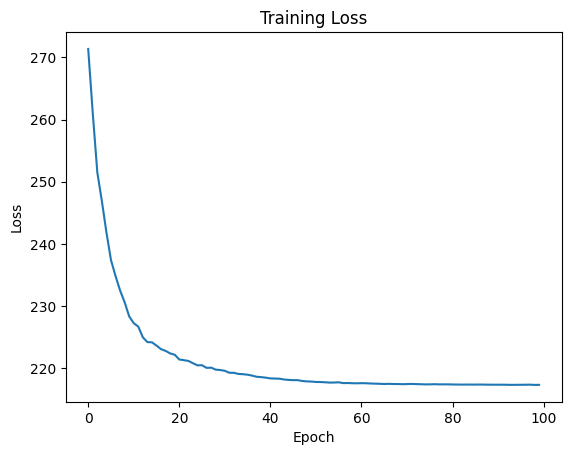

Model saved to gcrn_ip_dom1.pth


In [36]:

model_ip = GCRN_ip(input_dim, feature_dim, hidden_rec_dim, num_rec_layers)
print(model_ip)
print(f"Total number of trainable parameters: {model_ip.count_parameters()}")

train_model(model_ip, x_try1, adj_try1, num_epochs=100, lr=0.0001, save_path="gcrn_ip_dom1.pth")

GCRN_gcn(
  (encoder): GCNEncoder(
    (conv1): GCN (16 -> 32)
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GCN (32 -> 16)
    (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_mu): Linear(in_features=16, out_features=16, bias=True)
    (fc_logvar): Linear(in_features=16, out_features=16, bias=True)
  )
  (decoder): GCNDecoder(
    (fc): Linear(in_features=35, out_features=1225, bias=True)
    (conv1): GCN (35 -> 70)
    (bn1): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GCN (70 -> 35)
    (bn2): BatchNorm1d(35, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (gru): GRU(16, 35, num_layers=2)
)
Total number of trainable parameters: 64152
Epoch 1, Loss: 641.4723701477051
Epoch 2, Loss: 611.215410232544
Epoch 3, Loss: 572.2378311157227
Epoch 4, Loss: 559.610950088501
Epoch 5, Loss: 539.6043468475342
Epoch 6, Loss: 49

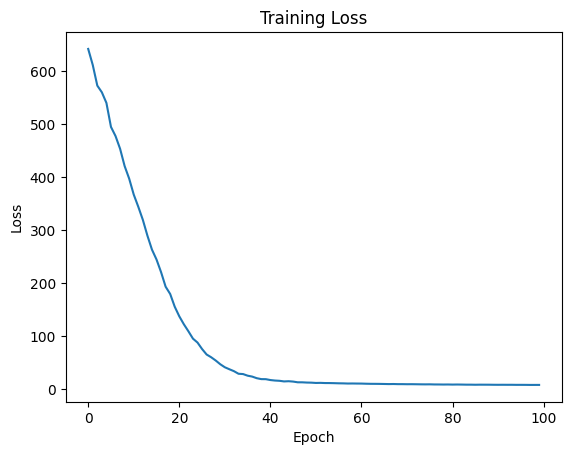

Model saved to gcrn_gcn_dom1.pth


In [64]:

model_gcn = GCRN_gcn(input_dim, feature_dim, hidden_rec_dim, num_rec_layers)
print(model_gcn)
print(f"Total number of trainable parameters: {model_gcn.count_parameters()}")

train_model(model_gcn, x_try1, adj_try1, num_epochs=100, lr=0.0001, save_path="gcrn_gcn_dom1.pth")

In [38]:

model_ffn = GCRN_ffn(input_dim, feature_dim, hidden_rec_dim, num_rec_layers)
print(model_ffn)
print(f"Total number of trainable parameters: {model_ffn.count_parameters()}")

train_model(model_ffn, x_try1, adj_try1, num_epochs=100, lr=0.0001, save_path="gcrn_ffn_dom1.pth")

GCRN_ffn(
  (encoder): GCNEncoder(
    (conv1): GCN (16 -> 32)
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GCN (32 -> 16)
    (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_mu): Linear(in_features=16, out_features=16, bias=True)
    (fc_logvar): Linear(in_features=16, out_features=16, bias=True)
  )
  (decoder): GCNDecoder(
    (fc): Linear(in_features=35, out_features=1225, bias=True)
    (conv1): GCN (35 -> 70)
    (bn1): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GCN (70 -> 35)
    (bn2): BatchNorm1d(35, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_adj): Linear(in_features=35, out_features=1225, bias=True)
  )
  (gru): GRU(16, 35, num_layers=2)
)
Total number of trainable parameters: 108252


RuntimeError: shape '[35, 35]' is invalid for input of size 42875

### Inference

In [58]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Function to plot heatmaps
def plot_heatmaps(input_adj, ground_truth_adj, reconstructed_adj):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(input_adj.cpu().detach().numpy(), cmap="YlGnBu", interpolation='nearest')
    ax[0].set_title('Input Graph')

    ax[1].imshow(ground_truth_adj.cpu().detach().numpy(), cmap="YlGnBu", interpolation='nearest')
    ax[1].set_title('Ground Truth Graph')

    ax[2].imshow(reconstructed_adj.cpu().detach().numpy(), cmap="YlGnBu", interpolation='nearest')
    ax[2].set_title('Reconstructed Graph')

    plt.show()

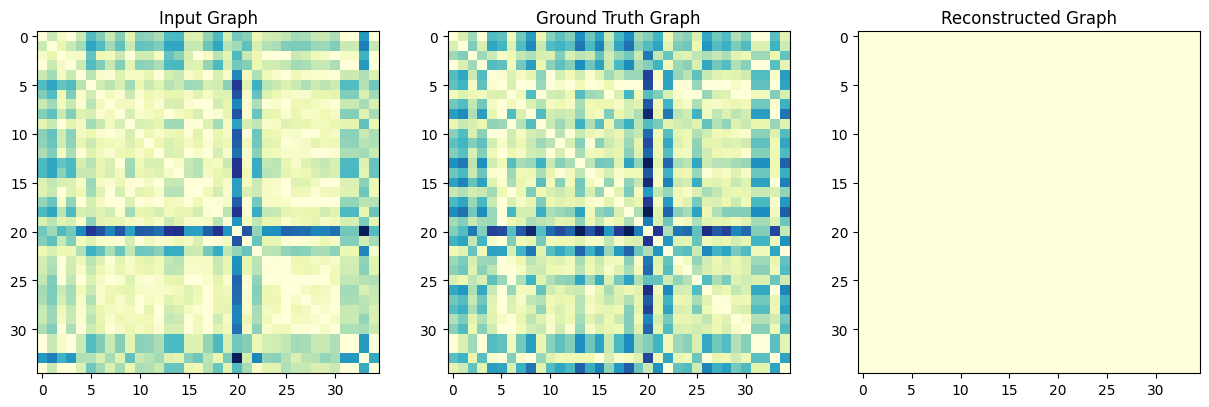

In [61]:

# Load the saved model
model = GCRN_ip(input_dim, feature_dim, hidden_rec_dim, num_rec_layers)
model.load_state_dict(torch.load('gcrn_ip_dom1.pth'))
model.eval()

# Select a sample from the training data
sample_idx = 0
x_t = x_try1[sample_idx, 0]  # Current time point node features
adj_t = adj_try1[sample_idx, 0]  # Current time point adjacency matrix
adj_t_next = adj_try1[sample_idx, 1]  # Next time point adjacency matrix (ground truth)

# Perform inference
with torch.no_grad():
    recon_adj, mu, logvar = model(x_t, adj_t)

# Plot heatmaps
plot_heatmaps(adj_t, adj_t_next, recon_adj)


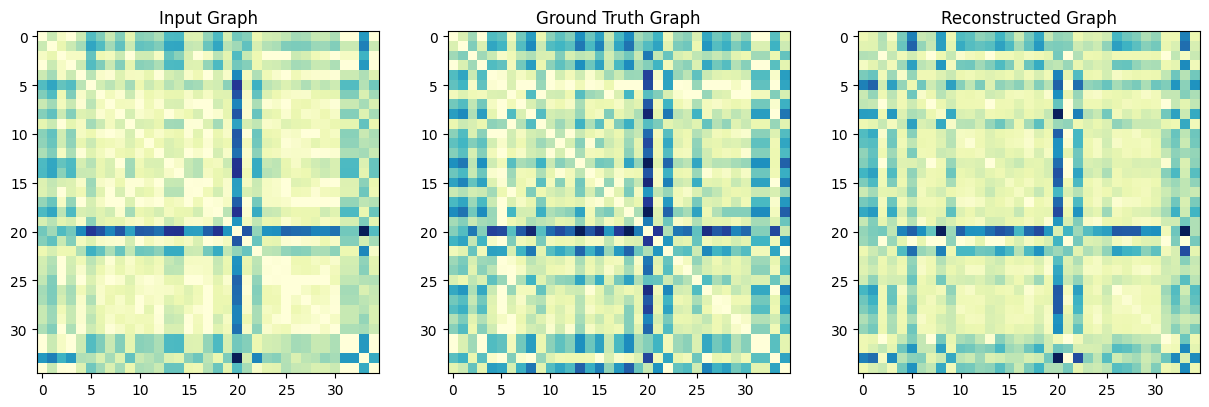

In [65]:

# Load the saved model
model = GCRN_gcn(input_dim, feature_dim, hidden_rec_dim, num_rec_layers)
model.load_state_dict(torch.load('gcrn_gcn_dom1.pth'))
model.eval()

# Select a sample from the training data
sample_idx = 0
x_t = x_try1[sample_idx, 0]  # Current time point node features
adj_t = adj_try1[sample_idx, 0]  # Current time point adjacency matrix
adj_t_next = adj_try1[sample_idx, 1]  # Next time point adjacency matrix (ground truth)

# Perform inference
with torch.no_grad():
    recon_adj, mu, logvar = model(x_t, adj_t)

# Plot heatmaps
plot_heatmaps(adj_t, adj_t_next, recon_adj)


### Evaluation